## Question 1

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

### Part 4

In [4]:
def eigen_vals(t, U):
    # Create hamiltonian matrix
    H = np.matrix(
        [
            [0, 0, -t, -t],
            [0, 0, t, t],
            [-t, t, U, 0],
            [-t, +t, 0, U]
        ]
    )

    # Generate values and vectors
    H_values, H_vectors = np.linalg.eig(H)
    
    return H_values

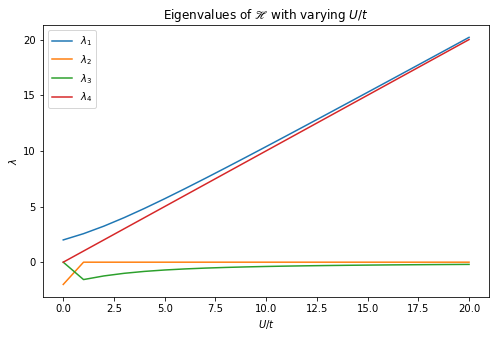

In [33]:
# Generate eigenvals for varying U/t and store them in an array
eigen_vals_array = []
spacing = 1
U_t_vals = np.arange(0, 20+spacing, spacing)

for val in np.arange(0, 20+spacing, spacing):
    eigen_vals_array.append(eigen_vals(1, val))

# Convert to numpy array to make manipulation easier
eigen_vals_array = np.array(eigen_vals_array)

fig = plt.figure(figsize=(8,5))

for index in range(0, 4):
    plt.plot(U_t_vals, eigen_vals_array[:, index], label=f'$\lambda_{index+1}$')
    
plt.title("Eigenvalues of $\mathscr{H}$ with varying $U/t$")
plt.xlabel("$U/t$")
plt.ylabel('$\lambda$')
plt.legend()

## Question 2

### Part 2

In [40]:
N_s = 256 
j = np.arange(-N_s/2+1, N_s/2+1, 1)
k = (2*np.pi*j)/N_s
N = 128 

# Defining the algorithm
def E_against_M(k, N_s, N, t=1, U=0.1):
    '''
    Function that finds the minimum energy state of 
    the mean field Hamiltonian for a given t, and U 
    '''

    # Generate all N_up, N_down pairs
    N_up = np.arange(0, N+1, 1)
    N_down = np.flip(N_up)

    # Generate each mean field
    n_up = N_up/N_s
    n_down = N_down/N_s

    # Define energy eigenfunctions for each k 
    e_k = -2*t*np.cos(k)
        
    def E(k, N_up_val, N_down_val, n_up_val, n_down_val):
        '''
        Returns each E_sigma value summed up to the 
        N_sigma lowest energy state
        '''
        eMF_up = np.sort(e_k + U*n_down_val)
        eMF_down = np.sort(e_k + U*n_up_val)

        E_up = np.sum(eMF_up[:N_up_val])
        E_down = np.sum(eMF_down[:N_down_val])
        
        return E_up, E_down
        
    # Calculate ground state energy for each M 
    energy = []
    for index in range(N+1):
        E_up, E_down = E(k, N_up[index], N_down[index], n_up[index], n_down[index])
        new_energy = (E_up+E_down)/N_s - (U*n_up[index]*n_down[index])
        energy.append(new_energy)

    # Find the min E value and corresponding M
    min_energy = min(energy)
    min_index = energy.index(min_energy)
    min_M = (N_up[min_index] - N_down[min_index])/N

    # Calculate all M
    M = (N_up - N_down)/N
    
    return M, energy, min_M, min_energy

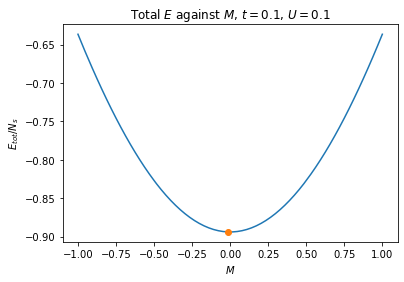

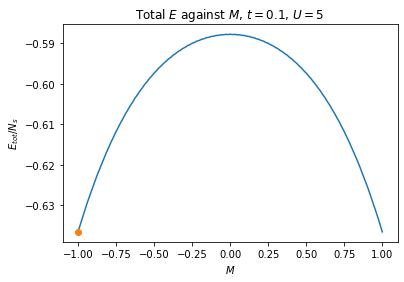

In [45]:
# --------------------- Part (e) --------------------------
# Plot below the Stoner Transition
M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=0.1)

fig = plt.figure()
plt.title(f"Total $E$ against $M$, $t=0.1$, $U=0.1$")
plt.xlabel('$M$')
plt.ylabel('$E_{tot}/N_s$')
plt.plot(M, energy)
plt.plot(min_M, min_energy, marker='o')


# Plot above the Stoner Transition
M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=5)

fig = plt.figure()
plt.title(f"Total $E$ against $M$, $t=0.1$, $U=5$")
plt.xlabel('$M$')
plt.ylabel('$E_{tot}/N_s$')
plt.plot(M, energy)
plt.plot(min_M, min_energy, marker='o')

### Part 3

In [43]:
# Generate minimum energy values
M_min_vals = []
U_vals = np.arange(2.1, 6, 0.1)
for U in U_vals:
    M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=U)
    M_min_vals.append(min_M)

Text(0.5, 1.0, '$U$ as a Function of Energy-Minimising $M$ Values')

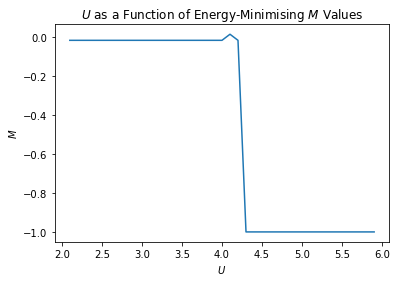

In [47]:
fig = plt.figure()
plt.plot(U_vals, M_min_vals)
plt.xlabel("$U$")
plt.ylabel("$M$")
plt.title("$U$ as a Function of Energy-Minimising $M$ Values")

From the plot above, we can estimate $U \approx 4.25$ as the critical $U$ value at which the magnetisation makes the transition from $M=0$ to a ferromagnet.